# Introduction 

Refer to this GeekforGeeks [article](https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/) .

# Steps



## Step 1: Import Libraries and Prepare Data

In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
data = np.sin(t)

data.shape

(1000,)

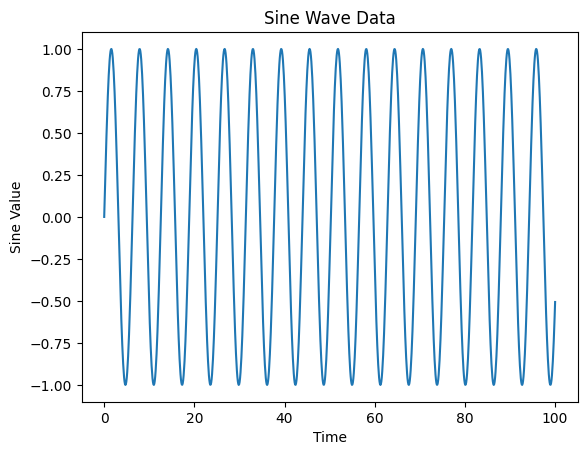

In [2]:
# Plot the data
plt.plot(t, data)
plt.xlabel('Time')
plt.ylabel('Sine Value')
plt.title('Sine Wave Data')
plt.show()

In [3]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (990, 10)
y.shape: (990,)


In [4]:
# Convert data to PyTorch tensors
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

print(f"trainX.shape: {trainX.shape}")
print(f"trainY.shape: {trainY.shape}")

trainX.shape: torch.Size([990, 10, 1])
trainY.shape: torch.Size([990, 1])


## Step 2: Define the LSTM Model

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # If hidden and cell states are not provided, initialize them as zeros
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward pass through LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Selecting the last output
        return out, hn, cn

## Step 3: Initialize Model, Loss Function, and Optimizer

In [6]:
# Initialize model, loss, and optimizer
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Step 4: Train the LSTM Model


In [7]:
# Training loop
num_epochs = 30
h0, c0 = None, None  # Initialize hidden and cell states

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs, h0, c0 = model(trainX, h0, c0)

    # Compute loss
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    # Detach hidden and cell states to prevent backpropagation through the entire sequence
    h0 = h0.detach()
    c0 = c0.detach()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/30], Loss: 0.2866
Epoch [20/30], Loss: 0.0900
Epoch [30/30], Loss: 0.0379


## Step 5: Evaluate and Plot Predictions


In [8]:
# Predicted outputs
model.eval()
predicted, _, _ = model(trainX, h0, c0)

# Adjusting the original data and prediction for plotting
original = data[seq_length:]  # Original data from the end of the first sequence
time_steps = np.arange(seq_length, len(data))  # Corresponding time steps


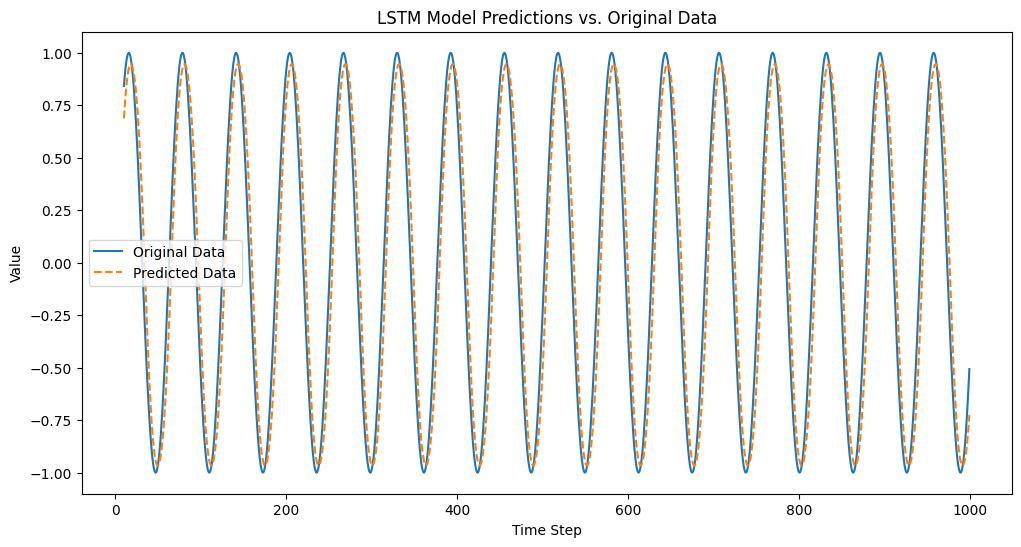

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()